In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [12]:
df = pd.read_csv("ETTh1.csv")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

target = "OT"

n = len(df)
train_size = int(n * 0.7)
val_size = int(n * 0.2)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]


In [13]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [14]:
INPUT_LEN = 96
PRED_LEN = 96

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, pred_len, target_idx):
        self.data = data
        self.input_len = input_len
        self.pred_len = pred_len
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.input_len - self.pred_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_len]
        y = self.data[idx + self.input_len : idx + self.input_len + self.pred_len, self.target_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [15]:
target_idx = df.columns.get_loc(target)

train_ds = TimeSeriesDataset(train_scaled, INPUT_LEN, PRED_LEN, target_idx)
val_ds   = TimeSeriesDataset(val_scaled, INPUT_LEN, PRED_LEN, target_idx)
test_ds  = TimeSeriesDataset(test_scaled, INPUT_LEN, PRED_LEN, target_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [16]:
class LSTMForecast(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -PRED_LEN:, :]
        out = self.fc(out).squeeze(-1)
        return out

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMForecast(n_features=train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            val_loss += criterion(preds, y).item()

    print(f"Epoch {epoch+1} | Train MSE: {train_loss/len(train_loader):.4f} | Val MSE: {val_loss/len(val_loader):.4f}")

Epoch 1 | Train MSE: 0.2811 | Val MSE: 0.4532
Epoch 2 | Train MSE: 0.2049 | Val MSE: 0.4301
Epoch 3 | Train MSE: 0.1581 | Val MSE: 0.7248
Epoch 4 | Train MSE: 0.1273 | Val MSE: 0.7174
Epoch 5 | Train MSE: 0.1011 | Val MSE: 0.7202
Epoch 6 | Train MSE: 0.0856 | Val MSE: 0.7042
Epoch 7 | Train MSE: 0.0754 | Val MSE: 0.8453
Epoch 8 | Train MSE: 0.0647 | Val MSE: 0.7941
Epoch 9 | Train MSE: 0.0573 | Val MSE: 0.7900
Epoch 10 | Train MSE: 0.0526 | Val MSE: 0.8482


In [19]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).cpu().numpy()
        y_pred.append(preds)
        y_true.append(y.numpy())

y_pred = np.concatenate(y_pred).ravel()
y_true = np.concatenate(y_true).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"LSTM MAE: {mae:.3f}")
print(f"LSTM RMSE: {rmse:.3f}")

LSTM MAE: 0.405
LSTM RMSE: 0.518


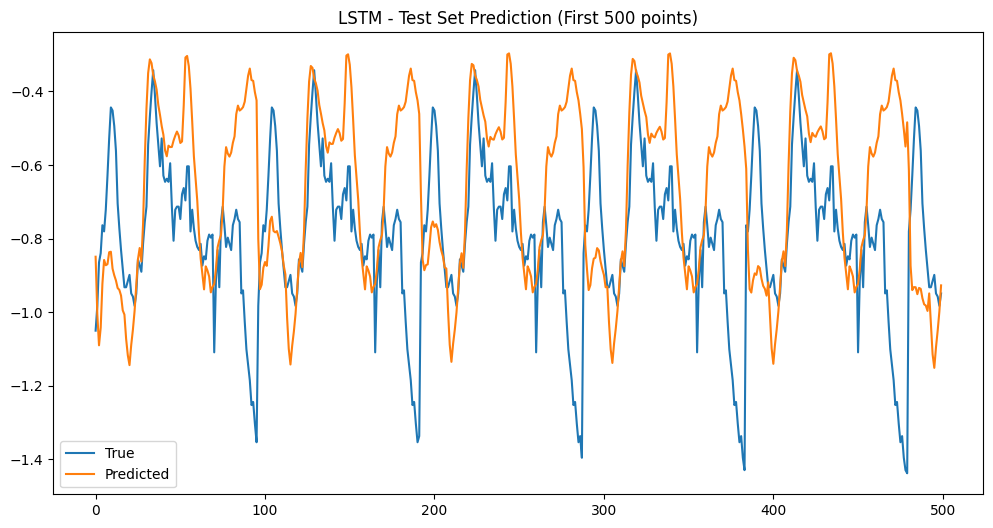

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:500], label="True")
plt.plot(y_pred[:500], label="Predicted")
plt.title("LSTM - Test Set Prediction (First 500 points)")
plt.legend()
plt.show()